In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from xgboost import XGBClassifier, plot_importance, Booster, plot_tree, to_graphviz, DMatrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from supertree import SuperTree # https://mljar.com/blog/visualize-xgboost-tree/
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
# CAA colors
colors_rgb_dict = {'Pale water blue' : (111/255,252/255,255/255),'Pale pink': (245/255,165/255,199/255),'Dark water green': (0/255,149/255,151/255),'Olive green' :(224/255,222/255,22/255), 'Pale water blue' : (111/255,252/255,255/255),\
                   'Water green' : (92/255,191/255,193/255),'Dark pink': (231/255,30/255,116/255),'Grey': (190/255,201/255,211/255), 'Pale blue' : (189/255,228/255,230/255), \
                   'Red' : (226/255,0/255,21/255), 'Dark blue grey' : (81/255,101/255,119/255) ,'Green' : (168/255,168/255,17/255), 'Dark grey' : (155/255,151/255,17/255), 'Pale grey': (231/255,230/255,230/255), 'Dark': (44/255,41/255,41/255)}
rgb_colors  = list(colors_rgb_dict.values())
caa_colors = []
for rgb_code in rgb_colors:
    px_rgb_code = 'rgb'+str(rgb_code)
    caa_colors.append(rgb_colors)

A decision tree is a popular machine learning algorithm used for both classification and regression tasks. It works by splitting a dataset into subsets based on the values of input features, creating a tree-like structure of decisions that lead to a final output or prediction. **The algorithm selects the best feature to split the data into subsets. The goal is to make each subset as pure as possible**. 

**XGBoost algorithm : Sequential way of building trees, each new ttree fixing errors of past trees**. Highly customizable and accurate in its predictions as it seeks to minimise the objective function:

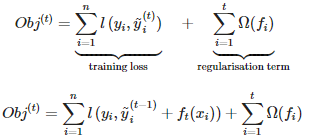

The first term (over all instances) measures the distance between the true label and the output from the model while the second term (over all trees) penalises models that are too complex. Optimising loss tend to create more complex models while optimizing regularisation tends to generalise simplier models.

# Data

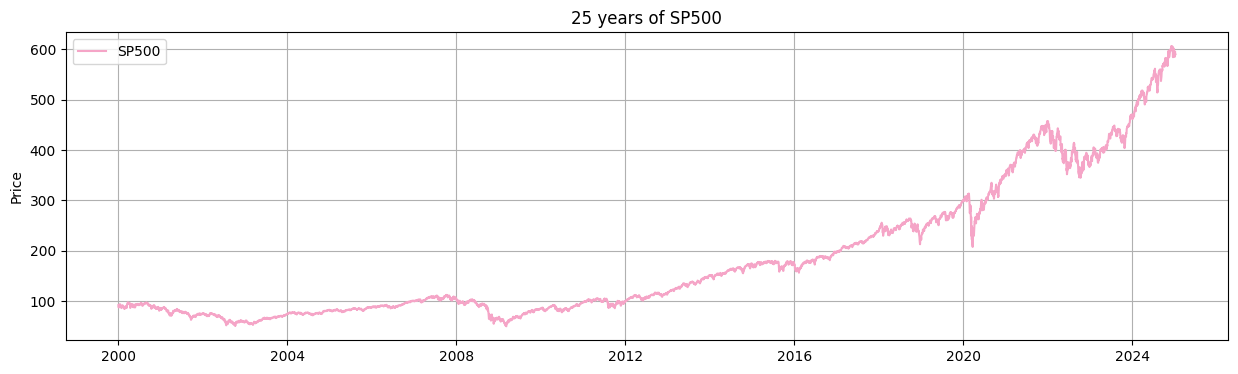

In [2]:
# Load file, calculate returns, plot
df = pd.read_excel('spy.xlsx', index_col=0, parse_dates=True)[['Adj Close']].loc['2000-01-01':]
df['Returns'] = np.log(df).diff()
df['Ret_1M'] = df['Returns'].rolling(20).sum()
plt.figure(figsize=(15, 4))
plt.plot(df['Adj Close'], linewidth=1.5, label='SP500', color=caa_colors[0][1])
plt.title('25 years of SP500')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.show()

In [4]:
# Create features (predictors) list - X dataset
features_list = []
for r in range(10, 65, 5):
    df['Ret_'+str(r)] = df.Returns.rolling(r).sum()
    df['Std_'+str(r)] = df.Returns.rolling(r).std()
    features_list.append('Ret_'+str(r))
    features_list.append('Std_'+str(r))
# Drop NaN values
df.dropna(inplace=True)

Label or the target variable is also known as the dependent variable. Here, the target variable is whether SP500 price will close up or down on the next trading day:
- If the tomorrow’s closing price is greater than today’s closing price, then we will buy the SPY (+1)
- else we do not invest (0).

$$
y_t = 1 \; \text{ if } p_{t+1} > 0.995 \times p_t \text{, else}\;0
$$
where $p_t$: current closing SP500 price and $p_{t+1}$ the 1-day forward closing price of SP500.

In [ ]:
# Define Target - Y
df['Target'] = np.where(df['Adj Close'].shift(-1)>0.995 * df['Adj Close'], 1, 0)  
df = df[:-1]
df

,Adj Close,Returns,Ret_1M,Ret_10,Std_10,Ret_15,Std_15,Ret_20,Std_20,Ret_25,...,Std_40,Ret_45,Std_45,Ret_50,Std_50,Ret_55,Std_55,Ret_60,Std_60,Target
Date,,,,,,,,,,,,,,,,,,,,,
2000-06-22,93.267357,-0.015333,0.039960,-0.006409,0.010383,0.004500,0.009922,0.039960,0.012431,0.005576,...,0.013515,0.010323,0.014409,-0.029954,0.017737,-0.028082,0.016995,-0.034307,0.016516,0
2000-06-23,92.466805,-0.008620,0.048645,-0.012899,0.010685,-0.021390,0.008964,0.048645,0.011860,0.009302,...,0.013574,0.011047,0.014399,-0.010765,0.017340,-0.030439,0.017013,-0.043962,0.016548,1
2000-06-26,93.657669,0.012797,0.060308,0.011691,0.010827,-0.003720,0.009616,0.060308,0.012077,0.037916,...,0.013691,0.019052,0.014505,0.016014,0.017319,-0.026297,0.017064,-0.014284,0.016500,0
2000-06-27,92.967140,-0.007400,0.020820,-0.014302,0.009174,-0.006650,0.009737,0.020820,0.010148,0.038073,...,0.013571,0.022576,0.014452,0.067507,0.015117,-0.040011,0.017063,-0.032970,0.016455,1
2000-06-28,93.227379,0.002795,0.021425,-0.013199,0.009222,-0.010765,0.009572,0.021425,0.010152,0.055703,...,0.013188,-0.015310,0.013098,0.035972,0.014352,-0.033287,0.017063,-0.035977,0.016440,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-30,588.219971,-0.011477,-0.020710,-0.023461,0.012648,-0.029401,0.010555,-0.020710,0.009301,-0.005863,...,0.008551,0.018744,0.008650,0.013389,0.008334,0.024128,0.008140,0.038656,0.008096,1
2024-12-31,586.080017,-0.003645,-0.026145,-0.031366,0.012435,-0.027883,0.010529,-0.026145,0.009294,-0.012602,...,0.008564,0.015445,0.008671,0.005906,0.008335,0.014513,0.008122,0.025966,0.008038,1
2025-01-02,584.640015,-0.002460,-0.029069,-0.029698,0.012431,-0.027229,0.010525,-0.029069,0.009288,-0.018448,...,0.008567,0.009898,0.008670,0.005089,0.008340,0.003908,0.008057,0.032587,0.007950,1


In [7]:
# Convert to NumPy
X = df.drop(['Adj Close', 'Returns', 'Ret_1M', 'Target'], axis=1)
print(f'X features shape: {X.shape}')
X

X features shape: (6173, 22)


,Ret_10,Std_10,Ret_15,Std_15,Ret_20,Std_20,Ret_25,Std_25,Ret_30,Std_30,...,Ret_40,Std_40,Ret_45,Std_45,Ret_50,Std_50,Ret_55,Std_55,Ret_60,Std_60
Date,,,,,,,,,,,,,,,,,,,,,
2000-06-22,-0.006409,0.010383,0.004500,0.009922,0.039960,0.012431,0.005576,0.012839,0.055227,0.013103,...,-0.003532,0.013515,0.010323,0.014409,-0.029954,0.017737,-0.028082,0.016995,-0.034307,0.016516
2000-06-23,-0.012899,0.010685,-0.021390,0.008964,0.048645,0.011860,0.009302,0.012708,0.024013,0.012629,...,-0.008841,0.013574,0.011047,0.014399,-0.010765,0.017340,-0.030439,0.017013,-0.043962,0.016548
2000-06-26,0.011691,0.010827,-0.003720,0.009616,0.060308,0.012077,0.037916,0.012475,0.026030,0.012689,...,0.010182,0.013691,0.019052,0.014505,0.016014,0.017319,-0.026297,0.017064,-0.014284,0.016500
2000-06-27,-0.014302,0.009174,-0.006650,0.009737,0.020820,0.010148,0.038073,0.012471,0.001490,0.012392,...,-0.010696,0.013571,0.022576,0.014452,0.067507,0.015117,-0.040011,0.017063,-0.032970,0.016455
2000-06-28,-0.013199,0.009222,-0.010765,0.009572,0.021425,0.010152,0.055703,0.011996,-0.005347,0.012271,...,0.012277,0.013188,-0.015310,0.013098,0.035972,0.014352,-0.033287,0.017063,-0.035977,0.016440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-30,-0.023461,0.012648,-0.029401,0.010555,-0.020710,0.009301,-0.005863,0.008563,-0.005323,0.008273,...,0.037213,0.008551,0.018744,0.008650,0.013389,0.008334,0.024128,0.008140,0.038656,0.008096
2024-12-31,-0.031366,0.012435,-0.027883,0.010529,-0.026145,0.009294,-0.012602,0.008560,0.003923,0.007949,...,0.029357,0.008564,0.015445,0.008671,0.005906,0.008335,0.014513,0.008122,0.025966,0.008038
2025-01-02,-0.029698,0.012431,-0.027229,0.010525,-0.029069,0.009288,-0.018448,0.008529,-0.002626,0.007927,...,0.029053,0.008567,0.009898,0.008670,0.005089,0.008340,0.003908,0.008057,0.032587,0.007950


In [8]:
# Define label or target 
y = df['Target']
print(f'y target shape: {y.shape}')
y


y target shape: (6173,)


Date
2000-06-22    0
2000-06-23    1
2000-06-26    0
2000-06-27    1
2000-06-28    0
             ..
2024-12-30    1
2024-12-31    1
2025-01-02    1
2025-01-03    1
2025-01-06    0
Name: Target, Length: 6173, dtype: int64

In [9]:
# Splitting the datasets into 80% training and 20% testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print(f"Train and Test Size {len(X_train)}, {len(X_test)}")

Train and Test Size 4938, 1235


# Fit model

In [10]:
# Scale and fit the xgboost classifier model
xgbcls =  XGBClassifier(verbosity = 0, silent=True, random_state=42)
xgbcls.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Train Accuracy: 0.987
Test Accuracy: 0.7231


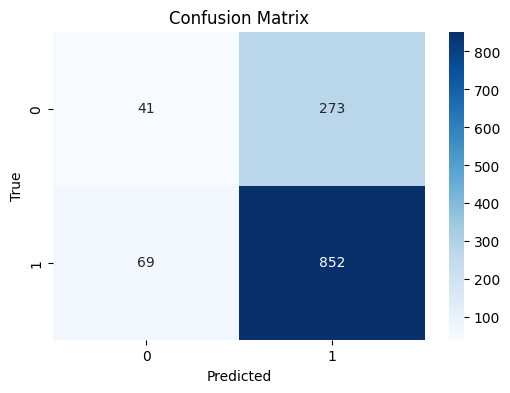

In [14]:
# Make predictions
y_pred = xgbcls.predict(X_test)
# Output prediction scoare
print(f'Train Accuracy: {xgbcls.score(X_train,y_train):0.4}')
print(f'Test Accuracy: {xgbcls.score(X_test,y_test):0.4}')
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=xgbcls.classes_, yticklabels=xgbcls.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [13]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.37      0.13      0.19       314
           1       0.76      0.93      0.83       921

    accuracy                           0.72      1235
   macro avg       0.57      0.53      0.51      1235
weighted avg       0.66      0.72      0.67      1235



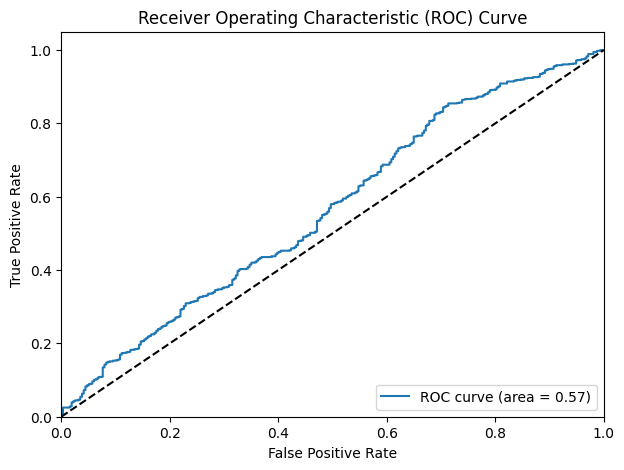

In [16]:
# Make predictions (probabilities)
y_pred_prob = xgbcls.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
# Plot the ROC curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Hyperparameter tuning

- **Learning rate**: Controls the contribution of each tree in the boosting process. It determines the step size at each iteration while moving toward a minimum of the loss function, e.g. the speed at which the tree learns
- **Max Depth**: Tree depth
- **Minimum Child Weight**: controls the complexity of the model by specifying the minimum sum of instance weights (hessians) needed in a child node. It helps to manage the depth of the trees and prevent overfitting.  ensures that each leaf node in the tree has a sufficient number of instances to make meaningful predictions. It helps in controlling overfitting by preventing the model from learning overly specific patterns from the training data.
- **gamma**: controls the minimum loss reduction required to make a further partition on a leaf node of the tree
- **Column sample by tree**: controls the randomness and diversity of the trees in the ensemble. It specifies the fraction of features (columns) to be randomly sampled for each tree

In [17]:
# Cross-validation
tscv = TimeSeriesSplit(n_splits=5, gap=1)
# Get params list
xgbcls.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': 0,
 'silent': True}

In [ ]:
# Hyper parameter optimization
param_grid = {'learning_rate': [0.10, 0.20, 0.30, 0.40],
              'max_depth': [3, 4, 5, 6],
              'min_child_weight': [3, 5, 7],
              'gamma': [0.2 , 0.4, 0.6],
              'colsample_bytree': [0.3, 0.5]}
rs = GridSearchCV(xgbcls, param_grid, scoring='f1', cv=tscv, verbose=0)
rs.fit(X_train, y_train, verbose=0)

GridSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, im...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'colsample_bytree': [0.3, 0.5],
                         'gamma': [0.2, 0.4, 0.6],
                         'learning_rate': [0.1, 0.2, 0.3, 0.4],
                         'max_depth': [3, 4, 5, 6],
                         'min_child_weight': [3, 5, 7]},
             scoring='f1')

In [19]:
# Print best parameters
print(rs.best_params_)
print(rs.best_score_)

{'colsample_bytree': 0.5, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5}
0.8430618937033267


In [20]:
# Refit the XGB Classifier with the best params
cls = XGBClassifier(**rs.best_params_) 
cls.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=True)

[0]	validation_0-logloss:0.54153	validation_1-logloss:0.56452
[1]	validation_0-logloss:0.53762	validation_1-logloss:0.56227
[2]	validation_0-logloss:0.53443	validation_1-logloss:0.56035
[3]	validation_0-logloss:0.53171	validation_1-logloss:0.55943
[4]	validation_0-logloss:0.52930	validation_1-logloss:0.55821
[5]	validation_0-logloss:0.52715	validation_1-logloss:0.55665
[6]	validation_0-logloss:0.52485	validation_1-logloss:0.55561
[7]	validation_0-logloss:0.52331	validation_1-logloss:0.55482
[8]	validation_0-logloss:0.52179	validation_1-logloss:0.55414
[9]	validation_0-logloss:0.52027	validation_1-logloss:0.55430
[10]	validation_0-logloss:0.51897	validation_1-logloss:0.55379
[11]	validation_0-logloss:0.51751	validation_1-logloss:0.55362
[12]	validation_0-logloss:0.51636	validation_1-logloss:0.55258
[13]	validation_0-logloss:0.51534	validation_1-logloss:0.55225
[14]	validation_0-logloss:0.51453	validation_1-logloss:0.55238
[15]	validation_0-logloss:0.51343	validation_1-logloss:0.55209
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

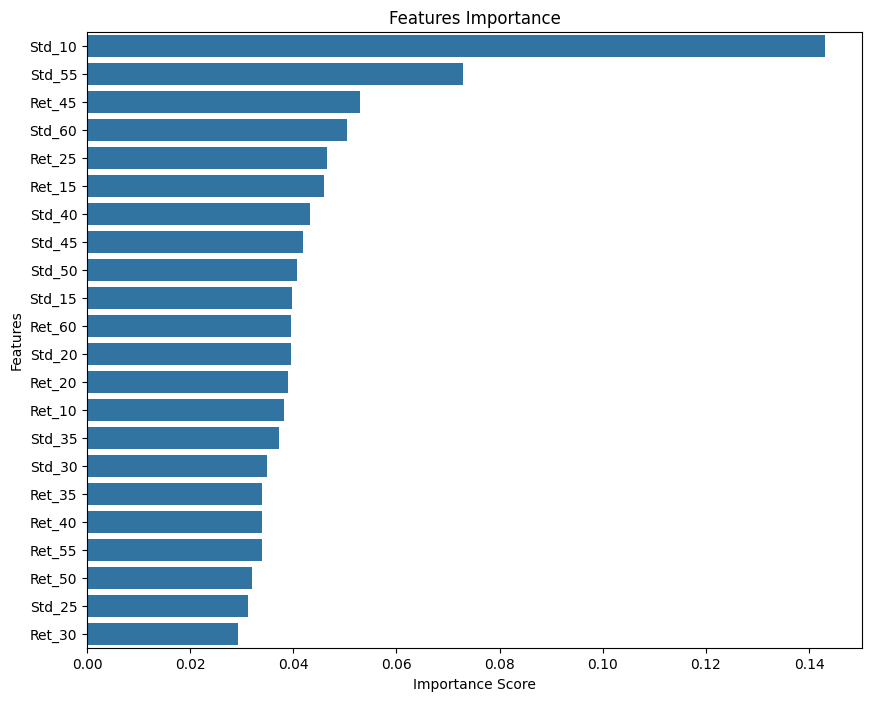

In [21]:
fig, ax = plt.subplots(figsize=(10,8))
feature_imp = pd.DataFrame({'Importance Score': cls.feature_importances_,'Features': X.columns}).sort_values(by='Importance Score', ascending=False)
sns.barplot(x=feature_imp['Importance Score'], y=feature_imp['Features'])
ax.set_title('Features Importance');

In [1]:
#st = SuperTree(
#    cls, 
#    X_train, 
#    y_train
#)
# Visualize the tree
#st.show_tree(which_tree=2)
#st.save_html() 

# Predict refitted model

In [23]:
# Estimate new model performance
y_fit = cls.predict(X_test)
# Measure Accuracy
acc_train = accuracy_score(y_train, cls.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)
print(f'Train Accuracy: {acc_train:0.4}')
print(f'Test Accuracy: {acc_test:0.4}')
# Classification Report
print(classification_report(y_test, y_fit))

Train Accuracy: 0.7736
Test Accuracy: 0.7231
              precision    recall  f1-score   support

           0       0.53      0.03      0.06       314
           1       0.75      0.99      0.85       921

    accuracy                           0.75      1235
   macro avg       0.64      0.51      0.46      1235
weighted avg       0.69      0.75      0.65      1235



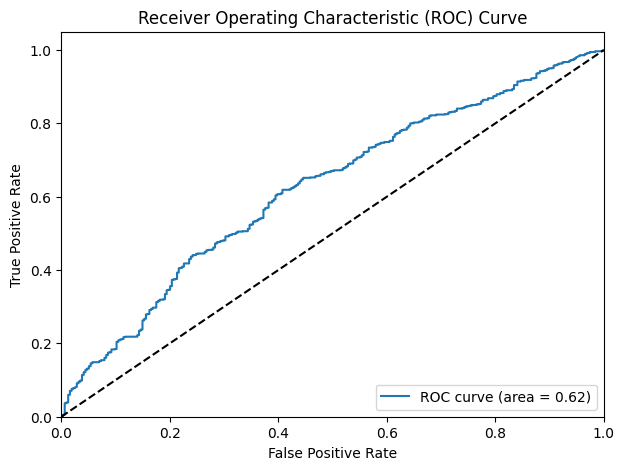

In [29]:
# Make predictions (probabilities)
y_fit_prob = cls.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_fit_prob)
auc = roc_auc_score(y_test, y_fit_prob)
# Plot the ROC curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [25]:
# Cross validation score
score=cross_val_score(cls,X_train,y_train,cv=tscv)
print(f'Mean CV Score : {score.mean():0.4}')

Mean CV Score : 0.7312


# Investment strategy
Compare to Buy-and-Hold and visualise the performance of the XGBoost tree predicitve algorithm
- **Buy**: if predicted class = 1
- **Don't buy**: if predicted class = 0



In [26]:
# Create a new dataframe to subsume outsample data
df1 = df[-len(y_test):]
# Predict the signal and store in predicted signal column
df1['Signal'] = y_pred
df1['Strategy'] = df1['Returns'] * df1['Signal'].shift(1).fillna(0)
# Localize index for pyfolio
df1.index = df1.index.tz_localize('utc')
rets = df1[['Returns','Strategy']]
rets.rename(columns={'Returns': 'SP500'}, inplace=True)
# Check the output
df1[['Adj Close', 'Returns', 'Signal', 'Strategy']].tail(10)


,Adj Close,Returns,Signal,Strategy
Date,,,,
2024-12-20 00:00:00+00:00,591.150024,0.011939,1,0.011939
2024-12-23 00:00:00+00:00,594.690002,0.005970,1,0.005970
2024-12-24 00:00:00+00:00,601.299988,0.011054,0,0.011054
2024-12-26 00:00:00+00:00,601.340027,0.000067,1,0.000000
2024-12-27 00:00:00+00:00,595.010010,-0.010582,1,-0.010582
2024-12-30 00:00:00+00:00,588.219971,-0.011477,1,-0.011477
2024-12-31 00:00:00+00:00,586.080017,-0.003645,1,-0.003645
2025-01-02 00:00:00+00:00,584.640015,-0.002460,1,-0.002460
2025-01-03 00:00:00+00:00,591.950012,0.012426,1,0.012426


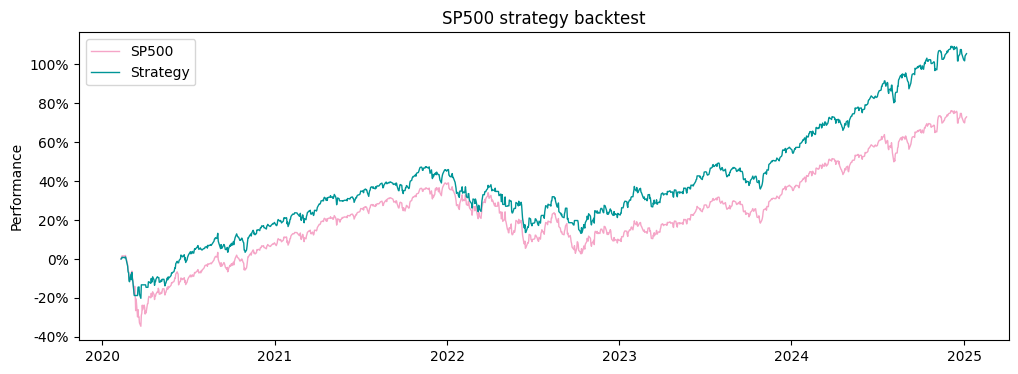

In [27]:
# Backtest
bt_df = pd.DataFrame(np.nan, index=df1.index, columns=['SP500','Strategy'])
bt_df['SP500'] = (1 + df1['Returns']).cumprod() - 1
bt_df['Strategy'] = (1 + df1['Strategy']).cumprod() - 1
bt_df.iloc[0,:] = 0
# Plot backtest
plt.figure(figsize=(12, 4))
for i in range(bt_df.shape[1]):
    plt.plot(bt_df.iloc[:,i], linewidth=1, label=bt_df.columns[i], color=caa_colors[0][i+1])
plt.title('SP500 strategy backtest')
plt.ylabel('Performance')
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])
plt.legend()
plt.show()

In [ ]:
# Calculate annualized return of all elements
table = [['SP500', round(100*((1 + bt_df['SP500'][-1])**(252/len(bt_df))-1),2), round(100*(np.std(rets['SP500']) * np.sqrt(252)),2), round(((1 + bt_df['SP500'][-1])**(252/len(bt_df))-1) / (np.std(rets['SP500']) * np.sqrt(252)),2)], \
         ['Strategy', round(100*((1 + bt_df['Strategy'][-1])**(252/len(bt_df))-1),2), round(100*(np.std(rets['Strategy']) * np.sqrt(252)),2), round(((1 + bt_df['Strategy'][-1])**(252/len(bt_df))-1) / (np.std(rets['Strategy']) * np.sqrt(252)),2)]]
header = ['Strategy','Annualized return (in %)','Annualized volatility (in %)','Risk-adjusted return']
print(tabulate(table,headers=header))

Strategy      Annualized return (in %)    Annualized volatility (in %)    Risk-adjusted return
----------  --------------------------  ------------------------------  ----------------------
SP500                            11.83                           21.2                     0.56
Strategy                         15.83                           17.61                    0.9
